In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Dataset1/Brain.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/images/2014.png  
  inflating: Dataset/images/2015.png  
  inflating: Dataset/images/2016.png  
  inflating: Dataset/images/2017.png  
  inflating: Dataset/images/2018.png  
  inflating: Dataset/images/2019.png  
  inflating: Dataset/images/202.png  
  inflating: Dataset/images/2020.png  
  inflating: Dataset/images/2021.png  
  inflating: Dataset/images/2022.png  
  inflating: Dataset/images/2023.png  
  inflating: Dataset/images/2024.png  
  inflating: Dataset/images/2025.png  
  inflating: Dataset/images/2026.png  
  inflating: Dataset/images/2027.png  
  inflating: Dataset/images/2028.png  
  inflating: Dataset/images/2029.png  
  inflating: Dataset/images/203.png  
  inflating: Dataset/images/2030.png  
  inflating: Dataset/images/2031.png  
  inflating: Dataset/images/2032.png  
  inflating: Dataset/images/2033.png  
  inflating: Dataset/images/2034.png  
  inflating: Dataset/images/2035.png  
  inflating: Da

In [4]:
np.random.seed(42)

In [5]:
## Convo Block

In [6]:
##Convo Block
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [7]:
## Encoder Block
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [8]:
## Decoder Block
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [9]:
## Unet
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

model = unet((256,256,3))
#model.summary()

In [10]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [11]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")

In [12]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [13]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [14]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [15]:
batch_size = 16
lr = 1e-4
num_epochs = 20
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")
dataset_path=r"/content/Dataset"

In [16]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

Train: (1840,1840)
Valid: (612,612)
Test: (612,612)


In [17]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [18]:
model = unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,'accuracy'])

In [19]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

In [20]:
s=model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=0,
    )


Epoch 1: val_loss improved from inf to 0.98142, saving model to files/model.h5

Epoch 2: val_loss improved from 0.98142 to 0.97856, saving model to files/model.h5

Epoch 3: val_loss improved from 0.97856 to 0.97325, saving model to files/model.h5

Epoch 4: val_loss improved from 0.97325 to 0.84830, saving model to files/model.h5

Epoch 5: val_loss did not improve from 0.84830

Epoch 6: val_loss improved from 0.84830 to 0.80745, saving model to files/model.h5

Epoch 7: val_loss did not improve from 0.80745

Epoch 8: val_loss improved from 0.80745 to 0.42358, saving model to files/model.h5

Epoch 9: val_loss improved from 0.42358 to 0.39325, saving model to files/model.h5

Epoch 10: val_loss improved from 0.39325 to 0.35179, saving model to files/model.h5

Epoch 11: val_loss improved from 0.35179 to 0.33331, saving model to files/model.h5

Epoch 12: val_loss did not improve from 0.33331

Epoch 13: val_loss did not improve from 0.33331

Epoch 14: val_loss did not improve from 0.33331

Ep

In [21]:
import pandas as pd
metrics = pd.read_csv("/content/files/log.csv")
metrics.head()

,epoch,accuracy,dice_coef,loss,lr,val_accuracy,val_dice_coef,val_loss
0,0,0.810235,0.116449,0.883551,0.0001,0.427494,0.018552,0.981418
1,1,0.965071,0.214117,0.785883,0.0001,0.924774,0.021350,0.978564
2,2,0.976799,0.284850,0.715150,0.0001,0.811423,0.026654,0.973248
3,3,0.983330,0.366149,0.633851,0.0001,0.966485,0.150546,0.848296
4,4,0.987298,0.454207,0.545793,0.0001,0.983491,0.128405,0.870640


<Axes: >

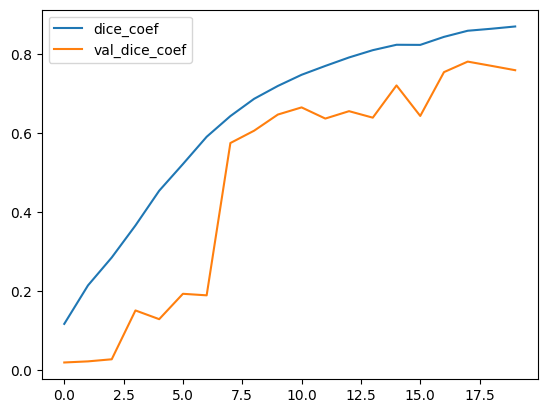

In [22]:
metrics[['dice_coef','val_dice_coef']].plot()

<Axes: >

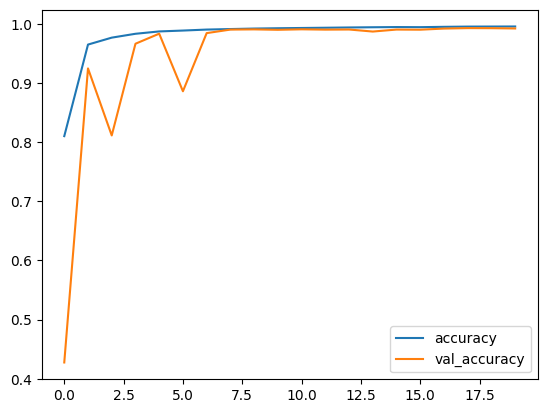

In [23]:
metrics[['accuracy','val_accuracy']].plot()

<Axes: >

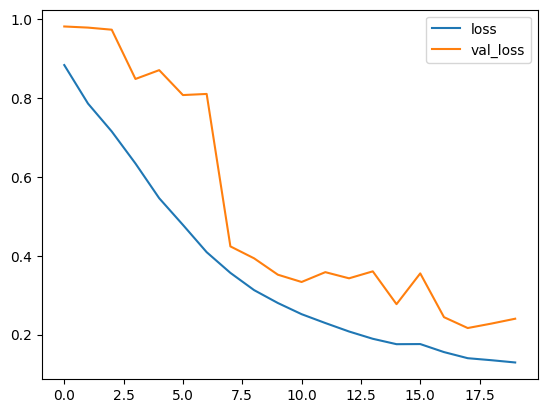

In [24]:
metrics[['loss','val_loss']].plot()

In [25]:
create_dir("results")

In [26]:
from tqdm import tqdm
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [27]:
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv", index=None)

100%|██████████| 612/612 [01:59<00:00,  5.12it/s]

F1: 0.68471
Jaccard: 0.59890
Recall: 0.67827
Precision: 0.75756


In [28]:
scores = pd.read_csv("/content/files/score.csv")
scores.head()

,Image,F1,Jaccard,Recall,Precision
0,833.png,0.865945,0.763583,0.915493,0.821485
1,2069.png,0.840411,0.724749,1.000000,0.724749
2,3038.png,0.596213,0.424717,0.760125,0.490452
3,1169.png,0.957637,0.918717,0.925647,0.991917
4,501.png,0.930636,0.870270,0.948454,0.913475


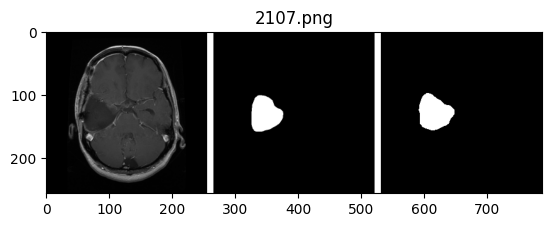

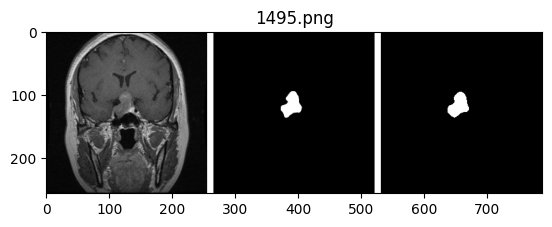

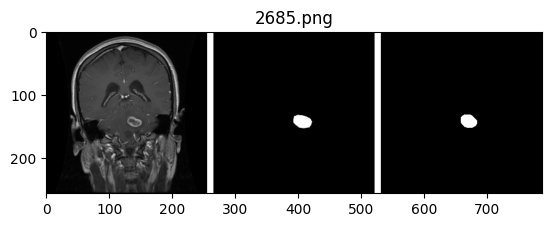

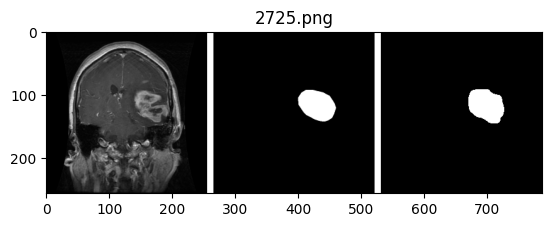

In [29]:
import os
import matplotlib.pyplot as plt

dir = "/content/results"
image_filenames = os.listdir(dir)[:4]  # Read the first 4 image filenames in the directory

for filename in image_filenames:
    img_path = os.path.join(dir, filename)
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(filename)
    plt.show()
